In [1]:
import geopandas as gpd # Geospatial data operations
import rasterio as rio # Geospatial imagery manipulation
import rasterio.plot
import pandas as pd # Tabular data
import os
import re
import rapidfuzz # Fuzzy string matching
from tqdm.auto import tqdm # Progress bars
import matplotlib # Plots
import matplotlib.pyplot as plt
import shapely # Polygon operations
import solaris.tile as tile # Tile splitting
import solaris.data.coco as coco
import contextlib
import io
import rasterio
from rasterio.vrt import WarpedVRT
from rasterio import transform
matplotlib.rcParams['figure.figsize'] = (20, 10)
tqdm.pandas()
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 130)

In [2]:
# A complete filelist of the MaxarImagery & Retrolens folders, generated with the unix command:
# find MaxarImagery/ Retrolens/ > ressci201900060-RNC2-Coastal_MaxarImagery_Retrolens_filelist.txt
filelist = pd.read_csv("ressci201900060-RNC2-Coastal_MaxarImagery_Retrolens_filelist.txt", header=None).iloc[:,0]
filelist

0                                                                         MaxarImagery/
1                                                              MaxarImagery/._.DS_Store
2                                                                 MaxarImagery/HighFreq
3                                                       MaxarImagery/HighFreq/HawkesBay
4                                           MaxarImagery/HighFreq/HawkesBay/._.DS_Store
                                              ...                                      
141473            Retrolens/Wellington/PukeruaBay/Stack/PukeruaBay_01AUG1942_mosaic.jp2
141474    Retrolens/Wellington/PukeruaBay/Stack/PukeruaBay_01AUG1942_mosaic.jp2.aux.xml
141475    Retrolens/Wellington/PukeruaBay/Stack/PukeruaBay_22AUG1961_mosaic.tif.aux.xml
141476    Retrolens/Wellington/PukeruaBay/Stack/PukeruaBay_20SEP1980_mosaic.jp2.aux.xml
141477        Retrolens/Wellington/PukeruaBay/Stack/PukeruaBay_04APR1986_mosaic.jp2.ovr
Name: 0, Length: 141478, dtype: 

In [3]:
def check_filename(filename):
    if "Taranaki" in filename:
        return False
    else:
        # This regex only matches shapefiles that contain something date-like in their names
        match = re.search(r'/Shorelines/\w+\d\w+\d{4}\w*.shp$', filename)
        return bool(match)

df = filelist[filelist.apply(check_filename)].to_frame(name="filename")
df

,filename
1344,MaxarImagery/HighFreq/Nelson/Nelson/Shorelines/Nelson_13DEC2013.shp
1368,MaxarImagery/HighFreq/Nelson/Nelson/Shorelines/Nelson_22NOV2017.shp
1371,MaxarImagery/HighFreq/Nelson/Nelson/Shorelines/Nelson_14DEC2006.shp
1375,MaxarImagery/HighFreq/Nelson/Nelson/Shorelines/Nelson_18MAR2021.shp
1385,MaxarImagery/HighFreq/Nelson/Nelson/Shorelines/Nelson_08FEB2016.shp
...,...
140219,Retrolens/Wellington/KapitiSouth/Shorelines/KapitiSouth_29OCT1973.shp
140221,Retrolens/Wellington/KapitiSouth/Shorelines/KapitiSouth_15APR1966.shp
140224,Retrolens/Wellington/KapitiSouth/Shorelines/KapitiSouth_17APR1952.shp
140278,Retrolens/Wellington/KapitiSouth/Shorelines/KapitiSouth_02JAN1988.shp


In [4]:
images = filelist[filelist.str.contains("/Stack/", case=False) & filelist.str.endswith((".jpg", ".jp2", ".tif"))]
images

236       MaxarImagery/HighFreq/HawkesBay/Mahanga/Imagery/Stack/Mahanga_08NOV2019_2.tif
237       MaxarImagery/HighFreq/HawkesBay/Mahanga/Imagery/Stack/Mahanga_08NOV2019_1.tif
239         MaxarImagery/HighFreq/HawkesBay/Mahanga/Imagery/Stack/Mahanga_12MAR2018.tif
242         MaxarImagery/HighFreq/HawkesBay/Mahanga/Imagery/Stack/Mahanga_31AUG2005.tif
254         MaxarImagery/HighFreq/HawkesBay/Mahanga/Imagery/Stack/Mahanga_25DEC2015.tif
                                              ...                                      
141460            Retrolens/Wellington/PukeruaBay/Stack/PukeruaBay_19NOV1972_mosaic.jp2
141466            Retrolens/Wellington/PukeruaBay/Stack/PukeruaBay_04APR1986_mosaic.jp2
141469            Retrolens/Wellington/PukeruaBay/Stack/PukeruaBay_10NOV1977_mosaic.tif
141470            Retrolens/Wellington/PukeruaBay/Stack/PukeruaBay_22AUG1961_mosaic.tif
141473            Retrolens/Wellington/PukeruaBay/Stack/PukeruaBay_01AUG1942_mosaic.jp2
Name: 0, Length: 1904, dtype: ob

In [5]:
# When fuzzy matching, ignore these strings
# _0 will ignore leading zeros in dates
strings_to_delete = ["_mosaic", "_mosiac", "_mosaid", ".mosaic", "_cliff", "_beach", "_beachcliffsegment", "_MF.shp", "_MT.shp", "_0", "_1.tif", "_2.tif", "_3.tif", "_LDS", "_"]

def fuzz_preprocess(filename):
    for s in strings_to_delete:
        filename = filename.replace(s, "")
    # Case-insensitive
    filename = filename.lower()
    # Ignore extension
    filename = os.path.splitext(filename)[0]
    # Basename only
    filename = os.path.basename(filename)
    return filename

def get_matching_image(filename):
    dirname = os.path.dirname(filename)
    RL_dirname = dirname.replace("Stack/", "").replace("Shorelines", "Stack").replace("MaxarImagery/HighFreq", "Retrolens")
    Maxar_dirname = dirname.replace("Imagery/Shorelines", "Imagery/Stack").replace("Shorelines", "Imagery/Stack").replace("Retrolens", "MaxarImagery/HighFreq")
    Maxar_dirname_uppercase = Maxar_dirname.replace("Stack", "STACK")
    Maxar_dirname_outside_Imagery = Maxar_dirname.replace("Imagery/Stack", "Stack")
    all_files_in_folder = images[images.str.startswith((RL_dirname, Maxar_dirname, Maxar_dirname_uppercase, Maxar_dirname_outside_Imagery))]
    if len(all_files_in_folder) == 0:
        return "", 0
    match, score, index = rapidfuzz.process.extractOne(query=filename, choices=all_files_in_folder, processor=fuzz_preprocess)
    return match, score

df["matched_image"], df["match_score"] = zip(*df.filename.apply(get_matching_image))
print("Perfect matches:", sum(df.match_score == 100))
print("Imperfect matches:", sum(df.match_score < 100))
df[["filename", "matched_image", "match_score"]].sort_values(by="match_score").to_csv("shoreline_image_matching.csv", index=False)

Perfect matches: 776
Imperfect matches: 122


In [6]:
# Get a random (known-good) annotation
sample = df[df.match_score == 100].sample(1)
display(sample)
image_filename = sample.matched_image.iloc[0]
image = rio.open(image_filename)
sample_gdf = gpd.read_file(sample.filename.iloc[0])
sample_gdf

,filename,matched_image,match_score
126677,Retrolens/WestCoast/GillespiesBeach/Shorelines/GillespiesBeach_15JAN1988.shp,Retrolens/WestCoast/GillespiesBeach/Stack/GillespiesBeach_15JAN1988_mosaic.jp2,100.0


,Id,Region,Site,Date,DSASDate,Digitiser,Scale,Notes,Source,geometry
0,0,WestCoast,GillespiesBeach,1988-01-15,15/01/1988,MD,2000,None,RLN,"LINESTRING (1340480.269 5187417.129, 1340499.319 5187408.662, 1340508.315 5187399.137, 1340519.428 5187379.029, 1340533.715 51..."


In [7]:
def line_to_split_bbox(geo):
    bounding_box = geo.envelope
    split_bbox = shapely.ops.split(bounding_box, geo)
    return split_bbox

split_bboxes = sample_gdf.geometry.apply(line_to_split_bbox).explode(index_parts=True).reset_index()
split_bboxes["area"] = split_bboxes.area
split_bboxes

,level_0,level_1,geometry,area
0,0,0,"POLYGON ((1340918.949 5187148.312, 1340480.269 5187148.312, 1340480.269 5187417.129, 1340499.319 5187408.662, 1340508.315 5187...",4.309974e+04
1,0,1,"POLYGON ((1344342.135 5190279.926, 1344342.135 5187148.312, 1340918.949 5187148.312, 1340938.000 5187150.428, 1340958.637 5187...",4.622084e+06
2,0,2,"POLYGON ((1344270.698 5190298.447, 1344342.135 5190298.447, 1344342.135 5190279.926, 1344320.440 5190288.393, 1344296.627 5190...",5.218144e+02
3,0,3,"POLYGON ((1340480.269 5187417.129, 1340480.269 5190298.447, 1344270.698 5190298.447, 1344238.419 5190296.859, 1344211.960 5190...",7.499696e+06


In [8]:
coastline = gpd.read_file("lds-nz-coastlines-and-islands-polygons-topo-150k-FGDB.zip!nz-coastlines-and-islands-polygons-topo-150k.gdb")

In [9]:
split_bboxes["area_inland"] = split_bboxes.overlay(coastline, how="intersection").area
split_bboxes["fraction_inland"] = split_bboxes.area_inland / split_bboxes.area
split_bboxes["class"] = split_bboxes.fraction_inland.apply(lambda f: "land" if f > .5 else "sea")
split_bboxes

,level_0,level_1,geometry,area,area_inland,fraction_inland,class
0,0,0,"POLYGON ((1340918.949 5187148.312, 1340480.269 5187148.312, 1340480.269 5187417.129, 1340499.319 5187408.662, 1340508.315 5187...",4.309974e+04,4.309974e+04,1.000000,land
1,0,1,"POLYGON ((1344342.135 5190279.926, 1344342.135 5187148.312, 1340918.949 5187148.312, 1340938.000 5187150.428, 1340958.637 5187...",4.622084e+06,4.622084e+06,1.000000,land
2,0,2,"POLYGON ((1344270.698 5190298.447, 1344342.135 5190298.447, 1344342.135 5190279.926, 1344320.440 5190288.393, 1344296.627 5190...",5.218144e+02,5.218144e+02,1.000000,land
3,0,3,"POLYGON ((1340480.269 5187417.129, 1340480.269 5190298.447, 1344270.698 5190298.447, 1344238.419 5190296.859, 1344211.960 5190...",7.499696e+06,1.932857e+05,0.025772,sea


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(5187148.311512251, 5190298.446979194)

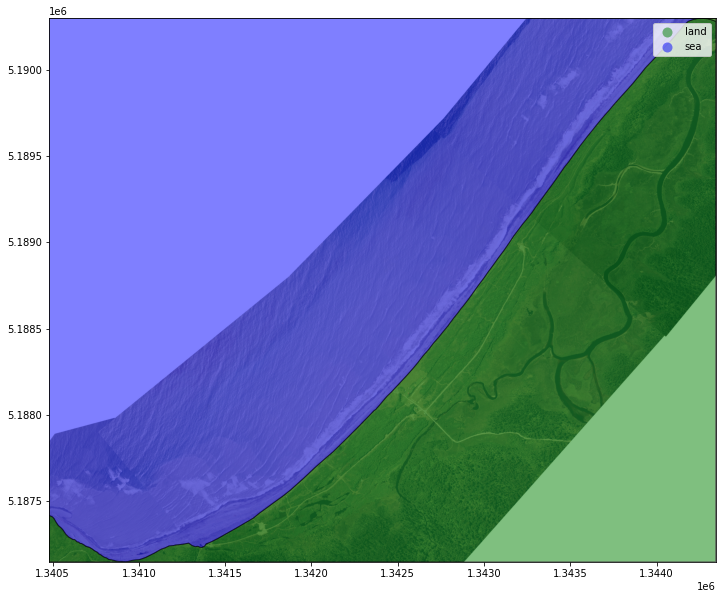

In [10]:
fig, ax = plt.subplots()
ax = rasterio.plot.show(image, ax=ax)

cmap = matplotlib.colors.ListedColormap(['green', 'blue'])
split_bboxes.plot(ax=ax, alpha=.5, column='class', cmap=cmap, categorical=True, legend=True, edgecolor='black')

#coastline.plot(ax=ax, alpha=.5, edgecolor="cyan")

b = split_bboxes.total_bounds
xlim = ([b[0], b[2]])
ylim = ([b[1], b[3]])
ax.set_xlim(xlim)
ax.set_ylim(ylim)

In [11]:
name = os.path.splitext(os.path.basename(sample.filename.iloc[0]))[0]
name

'GillespiesBeach_15JAN1988'

In [12]:
geojson_filename = f"polygon_annotations/{name}.geojson"
split_bboxes.to_file(geojson_filename, driver='GeoJSON')

In [13]:
split_bboxes.crs

<Projected CRS: EPSG:2193>
Name: NZGD2000 / New Zealand Transverse Mercator 2000
Axis Info [cartesian]:
- N[north]: Northing (metre)
- E[east]: Easting (metre)
Area of Use:
- name: New Zealand - North Island, South Island, Stewart Island - onshore.
- bounds: (166.37, -47.33, 178.63, -34.1)
Coordinate Operation:
- name: New Zealand Transverse Mercator 2000
- method: Transverse Mercator
Datum: New Zealand Geodetic Datum 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [14]:
image.profile

{'driver': 'JP2OpenJPEG', 'dtype': 'uint16', 'nodata': 256.0, 'width': 10192, 'height': 9754, 'count': 3, 'crs': CRS.from_wkt('PROJCS["NZGD2000 / New Zealand Transverse Mercator 2000",GEOGCS["NZGD2000",DATUM["New_Zealand_Geodetic_Datum_2000",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6167"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4167"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",173],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",1600000],PARAMETER["false_northing",10000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","2193"]]'), 'transform': Affine(0.5702486358810687, 0.0, 1339563.4386894351,
       0.0, -0.57024863588106, 5191145.4813708225), 'blockxsize': 1024, 'blockysize': 1024, 'tiled': True, 'interleave': 'pixel'}

In [15]:
if not image.crs and image.gcps:
    image_filename = "temp/" + os.path.basename(image_filename)
    with rasterio.open(image_filename, "w", **image.profile) as dst:
        dst.write(image.read())
        dst.transform = rasterio.transform.from_gcps(image.gcps[0])
        dst.crs = image.gcps[1]

In [20]:
for bounding_box in tqdm(split_bboxes.envelope):
    with contextlib.redirect_stdout(io.StringIO()):
        raster_tiler = tile.raster_tile.RasterTiler(
            dest_dir="training_tiles",  # the directory to save images to
            src_tile_size=(800, 800),  # the size of the output chips
            verbose=False,
            aoi_boundary=bounding_box,
        )
        raster_bounds_crs = raster_tiler.tile(image_filename, restrict_to_aoi=True, nodata_threshold=.5, dest_fname_base=name)
        vector_tiler = tile.vector_tile.VectorTiler(
            dest_dir=f"training_tiles",
            verbose=False
        )
        vector_tiler.tile(
            geojson_filename,
            tile_bounds=raster_tiler.tile_bounds,
            tile_bounds_crs=raster_bounds_crs,
            dest_fname_base=name,
        )

  0%|          | 0/4 [00:00<?, ?it/s]

In [21]:
coco_geojson = coco.geojson2coco(
    "training_tiles",
    "training_tiles",
    output_path=f"coco.json",
    matching_re=r"(\d{7}_\d{7})",
    category_attribute="class",
    explode_all_multipolygons=True,
    verbose=True,
)

  0%|          | 0/65 [00:00<?, ?it/s]